Using custom threshold: 0.1
Accuracy: 0.966
Precision: 0.918
Recall: 0.982
F1 Score: 0.949
ROC-AUC: 0.985
Confusion Matrix (Custom Threshold):
 	Predicted 0	Predicted 1
Actual 0	113	5
Actual 1	1	56

Thresholding Table (Standardized):
 Threshold	Accuracy	Precision	Recall	F1	ROC-AUC
0.100	0.966	0.918	0.982	0.949	0.985
0.200	0.966	0.918	0.982	0.949	0.985
0.300	0.966	0.918	0.982	0.949	0.985
0.400	0.966	0.918	0.982	0.949	0.985
0.500	0.966	0.918	0.982	0.949	0.985
0.600	0.966	0.918	0.982	0.949	0.985
0.700	0.943	0.961	0.860	0.907	0.985
0.800	0.931	0.959	0.825	0.887	0.985
0.900	0.931	0.959	0.825	0.887	0.985

Optimum Threshold (max F1): 0.1 with F1: 0.949
Gini Feature Importance:
 Feature	Gini Importance
1	0.045
2	0.065
3	0.700
4	0.000
5	0.010
6	0.153
7	0.015
8	0.012
9	0.000

Permutation Feature Importance (F1):
 Feature	Importance Mean	Importance Std
1	0.031	0.015
2	0.024	0.006
3	0.146	0.024
4	0.000	0.000
5	0.000	0.000
6	0.040	0.014
7	0.000	0.000
8	0.020	0.010
9	0.000	0.000



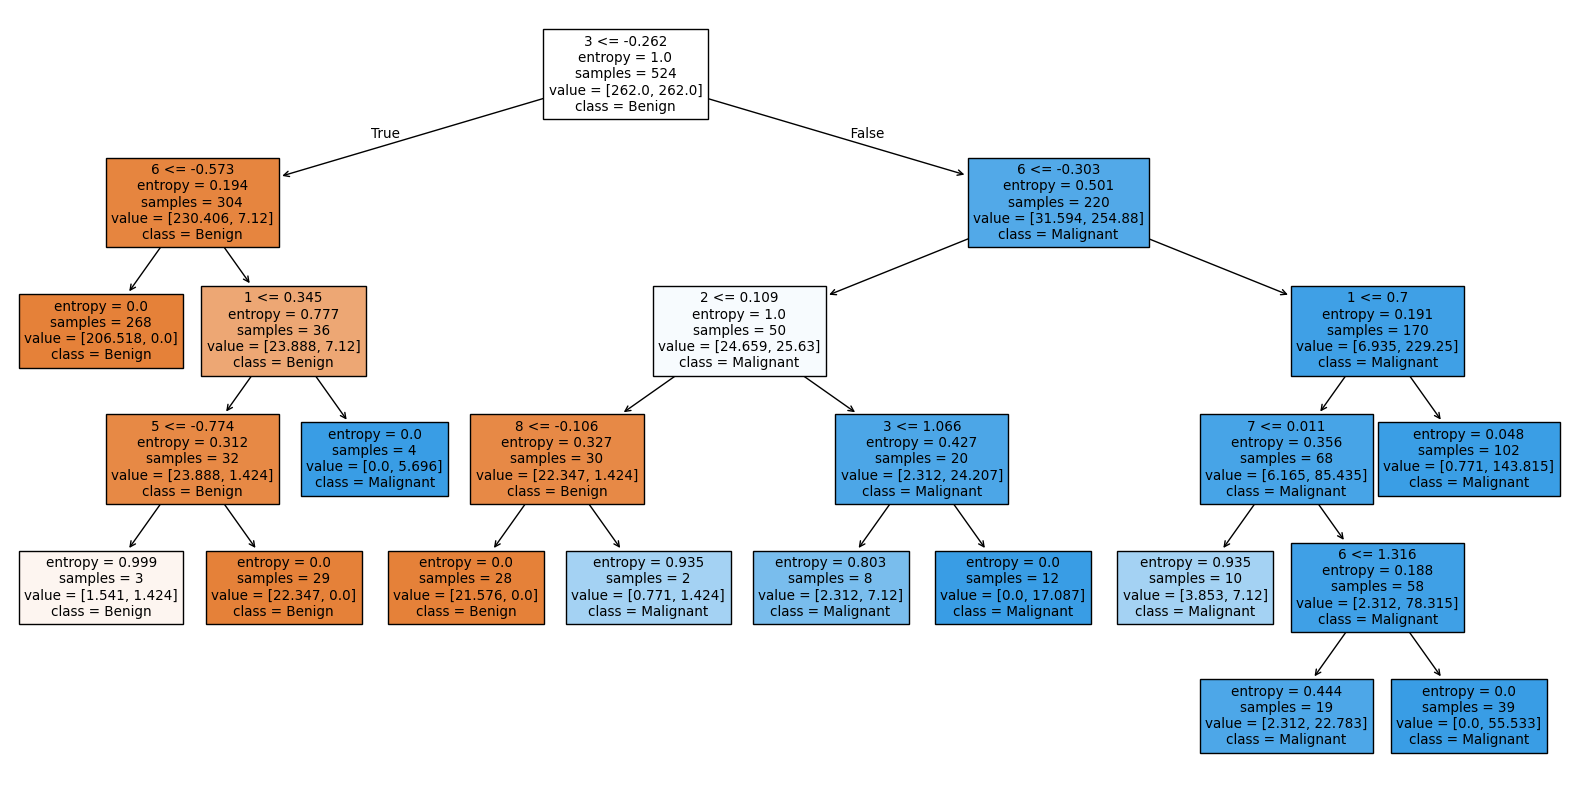

In [9]:
# decision_tree_tuned
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.inspection import permutation_importance
import io
import matplotlib.pyplot as plt  # For potential tree diagram

# Load data
df = pd.read_csv('breast-cancer-wisconsin_cleaned.csv', header=0)  # Use header row as column names
features = ['1', '2', '3', '4', '5', '6', '7', '8', '9']  # Features 1 through 9 as string indices
X = df[features]
y = df['10']  # Target (should be binary 0/1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tuned model with exact parameters from tuning
model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=2,
    criterion='entropy',
    max_leaf_nodes=12,
    min_impurity_decrease=0.0,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Set custom threshold (optimum based on best recall)
custom_threshold = 0.1  
print(f"Using custom threshold: {custom_threshold}")

# Predict with custom threshold
y_pred = np.where(y_prob > custom_threshold, 1, 0)

# Metrics with custom threshold (rounded to 3 decimal places)
accuracy = round(accuracy_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
recall = round(recall_score(y_test, y_pred, zero_division=0), 3)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)

# Confusion Matrix with custom threshold (tab-delimited for Word conversion)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
cm_text = cm_df.to_csv(sep='\t', index=True, header=True, float_format='%.0f')
print("Confusion Matrix (Custom Threshold):\n", cm_text)

# Thresholding Table for reference (tab-delimited for Word conversion, rounded to 3 decimal places)
thresholds = np.arange(0.1, 1.0, 0.1)  # [0.1, 0.2, ..., 0.9]
threshold_results = []
best_f1 = 0
best_threshold = 0.5  # Default
for threshold in thresholds:
    y_pred_thresh = np.where(y_prob > threshold, 1, 0)
    acc_thresh = round(accuracy_score(y_test, y_pred_thresh), 3)
    precision_thresh = round(precision_score(y_test, y_pred_thresh, zero_division=0), 3)
    recall_thresh = round(recall_score(y_test, y_pred_thresh, zero_division=0), 3)
    f1_thresh = round(f1_score(y_test, y_pred_thresh), 3)
    roc_auc_thresh = round(roc_auc_score(y_test, y_prob), 3)
    threshold_results.append([round(threshold, 3), acc_thresh, precision_thresh, recall_thresh, f1_thresh, roc_auc_thresh])
    if f1_thresh > best_f1:
        best_f1 = f1_thresh
        best_threshold = threshold
threshold_df = pd.DataFrame(threshold_results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'])
threshold_text = threshold_df.to_csv(sep='\t', index=False, header=True, float_format='%.3f')
print("Thresholding Table (Standardized):\n", threshold_text)
print(f"Optimum Threshold (max F1): {best_threshold} with F1: {best_f1}")

# Gini Feature Importance (rounded to 3 decimal places)
gini_importance_df = pd.DataFrame({
    'Feature': features,
    'Gini Importance': [round(val, 3) for val in model.feature_importances_]
})
gini_importance_text = gini_importance_df.to_csv(sep='\t', index=False, header=True, float_format='%.3f')
print("Gini Feature Importance:\n", gini_importance_text)

# Permutation Feature Importance with F1 scoring (rounded to 3 decimal places)
perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='f1')
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance Mean': [round(val, 3) for val in perm_importance.importances_mean],
    'Importance Std': [round(val, 3) for val in perm_importance.importances_std]
})
importance_text = importance_df.to_csv(sep='\t', index=False, header=True, float_format='%.3f')
print("Permutation Feature Importance (F1):\n", importance_text)

# Tree Diagram
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=features, class_names=['Benign', 'Malignant'], filled=True)
plt.show()